In [ ]:
from metavision_ml.preprocessing import histo
from metavision_sdk_cv import RotateEventsAlgorithm
import numpy as np
from metavision_core.event_io import RawReader
import matplotlib.pyplot as plt
import cv2
import time

file = input('Enter the path to the input file: ').strip() 
dt = 5000000 # 1s
record = RawReader(file, max_events=8000000)
# record.seek_time(1e6) # skip first second
events = record.load_delta_t(dt)
events['t'] -= events[0]['t'] # important! almost all preprocessing use relative time!
height, width = record.get_size()
tbins=15
algo = RotateEventsAlgorithm(width - 1, height - 1, .015)
buf = algo.get_empty_output_buffer()
algo.process_events(events, buf)

volume = np.zeros((tbins, 2, height, width), dtype=np.float32)

histo(buf.numpy(), volume, dt)

im = volume.sum(axis=0)[1] # sum over time
# normalize
im = im / im.max()
# clip negative values to 0
im[im < 0] = 0

# crop
im = im[150:250, 275:375]
height, width = im.shape

# D:\CZI_Scope\code\data\raw\recording_2024-03-19_17-43-40.raw (USAF Focus Chart)
# D:\CZI_Scope\code\data\raw\recording_2023-12-21_09-45-41_625_diffuser_no_motor_stationary.raw (Stationary bead)


date = time.strftime("%Y-%m-%d")
# cv2.imwrite(rf'D:\CZI_scope\code\data\imgs_and_plts\usaf_gr7el1_{date}.png', im*255)
plt.imshow(im)
plt.tight_layout()
#include axes for better orientation
plt.gca().invert_yaxis()
# place grids on every 50 pixels
plt.xticks(np.arange(0, width, 5))
# rotate x-axis labels
plt.xticks(rotation=45)
# show axes
plt.yticks(np.arange(0, height, 5))
# make the grid lines more transparent
plt.grid(alpha=0.3)
plt.title('USAF Focus Chart 5s Average', fontsize=20)
plt.show()

In [ ]:
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

magnification = 34
# Calculate the intensity profile along the horizontal axis
starting_line = (32, 47, 42, 47)
lines = [starting_line]
spacing = 3 # pixels
for i in range(1, 3):
    y = starting_line[1] - (i * spacing)
    lines.append((32, y, 42, y)) # 10 lines
# plot a line on the image
plt.imshow(im)
plt.tight_layout()
#include axes for better orientation
plt.gca().invert_yaxis()
# place grids on every 50 pixels
#plt.xticks(np.arange(0, width, 25))
# rotate x-axis labels
#plt.xticks(rotation=45)
# show axes
#plt.yticks(np.arange(0, height, 25))
# make the grid lines more transparent
#plt.grid(alpha=0.3)
# plot the line
for line in lines:
    l, = plt.plot([line[0], line[2]], [line[1], line[3]], 'r')
    l.set_linewidth(0.2)
# set the line width
plt.title('Stationary Bead 5s Average', fontsize=20)

# Add a white box to the plot
plt.gca().add_patch(plt.Rectangle((10, 80), 43, 15, fill=True, edgecolor='black', linewidth=0.5, facecolor='white', zorder=99))
# add a drop shadow to the box
plt.gca().add_patch(plt.Rectangle((8, 78), 43, 15, fill=True, edgecolor='black', linewidth=0, facecolor='black', alpha=0.2))
# Place text in the box
plt.text(12, 90, 'Bead Size: 1µm', fontsize=10, color='black', zorder=100)
plt.text(12, 85, 'Measured Size: 1.54µm', fontsize=10, color='black', zorder=100)

# Add a scale bar
um_to_px = magnification/15
plt.plot([80, 80 + 1 * um_to_px], [10, 10], 'w', linewidth=2)
# Add a scale bar label
plt.text(80 + 0.5 * um_to_px, 5, '1µm', color='white', fontsize=10, ha='center')

# calculate the intensity profile along the lines
scans = []
for line in lines:
    x1, y1, x2, y2 = line
    
    if x1 == x2:
        # Vertical line
        line_scan = im[min(y1, y2):max(y1, y2), x1]
    elif y1 == y2:
        # Horizontal line
        line_scan = im[y1, min(x1, x2):max(x1, x2)]
    else:
        # If lines are neither strictly horizontal nor vertical, handle as needed
        line_scan = im[min(y1, y2):max(y1, y2), min(x1, x2):max(x1, x2)]
    
    scans.append(line_scan)


intensity = np.mean(scans, axis=0)
intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())
# interpolate the intensity profile as spline
x = np.arange(len(intensity))
f = interp1d(x, intensity, kind='cubic')
x_new = np.linspace(0, len(intensity) - 1, int(1e3))
# normalize the intensity profile
intensity_interp = f(x_new)
# plot the intensity profile
plt.figure()
plt.plot(x_new, intensity_interp, label='Spline Interpolated') # plot the interpolated intensity profile
dot_size = 15 # Adjust this value to change the dot size
plt.scatter(x, intensity, color='red', s=dot_size, zorder=99, label='Original')
plt.title('Intensity Profile along the Horizontal Axis')
plt.legend()
plt.show()

# calculate the derivative of the interpolated intensity profile
derivative = np.gradient(intensity_interp)
# find the peaks in the derivative
peaks, _ = find_peaks(derivative)
# find the 3 highest peaks in the derivative
peaks = peaks[np.argsort(derivative[peaks])[-3:]]
# find the corresponding valleys
valleys = np.array([np.argmin(derivative[p:]) + p for p in peaks])
# find the y values of the peaks and valleys
peaks_x = x_new[peaks]
valleys_x = x_new[valleys]
# calculate the distances between the peak and valley pairs
distances = np.abs(peaks_x - valleys_x)
# calculate the resolution
resolution = 15 * distances / magnification
# mean resolution
mean_resolution = resolution.mean()
print(f'Mean resolution: {mean_resolution:.2f} um')

derivative = np.gradient(intensity)
peaks, _ = find_peaks(derivative)
peaks = peaks[np.argsort(derivative[peaks])[-3:]]
valleys = np.array([np.argmin(derivative[p:]) + p for p in peaks])
peaks_x = x[peaks]
valleys_x = x[valleys]
distances = np.abs(peaks_x - valleys_x)
resolution = 15 * distances / magnification
mean_resolution = resolution.mean()
print(f'Mean resolution: {mean_resolution:.2f} um')

mean_distance = distances.mean()
mean_distance


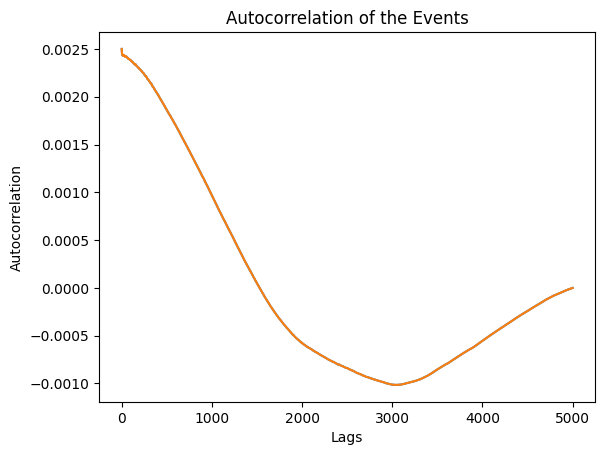

In [13]:
from metavision_ml.preprocessing import histo
from metavision_core.event_io import RawReader
from scipy.signal import correlate
import numpy as np
import holoviews as hv
import datashader as ds
import pandas as pd
from holoviews.operation.datashader import datashade
import matplotlib.pyplot as plt

file = input('Enter the path to the input file: ').strip()
reader = RawReader(file)
dt = int(1e6) # 1s
events = reader.load_delta_t(dt)
height, width = reader.get_size()
tsize = 200 # 200us
tbins = int(1e6 // tsize)
volume = np.zeros((tbins, 2, int(height//4), int(width//4)), dtype=np.float32)
histo(events, volume, dt, 2)
volume = volume.sum(axis=1) # sum over polarities
volume = volume.reshape(tbins, -1) # flatten the spatial dimensions
volume = volume.mean(axis=1) # average over space
evts_demeaned = volume - volume.mean(axis=0) # demean the events
autocorr = correlate(evts_demeaned, evts_demeaned, mode='full')
autocorr = autocorr[len(autocorr)//2:] # keep only the positive lags
# Prepare data for Holoviews and Datashader
lags = np.arange(len(autocorr))

plot_width = 800
plot_height = 400

# Create a Holoviews Curve element
# Use Datashader to render the curve efficiently

# Display the plot
plt.plot(lags, autocorr)
plt.title('Autocorrelation of the Events')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()
# free memory
del autocorr, volume, evts_demeaned